# General context

The [Learning Agency Lab - Automated Essay Scoring 2.0](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview) competition aims to enhance automated essay grading systems to support overburdened teachers, especially in underserved communities. It addresses the limitations of previous efforts by using a larger, more diverse dataset to improve scoring accuracy and fairness. Hosted by Vanderbilt University and The Learning Agency Lab, the competition seeks to develop open-source tools that provide timely feedback to students and integrate more effectively into real-world educational settings. This initiative represents a significant advancement in educational technology, promoting equitable access to reliable automated essay scoring.

In this notebook, I conducted exploratory data analysis and developed models using the Deberta V3 architecture ([He et al., 2021](https://arxiv.org/abs/2111.09543)). Additionally, I utilized the Hugging Face `datasets` library in conjunction with PyTorch's `DataLoader` for efficient data handling. I established a training loop using native PyTorch functionalities and modeled the outputs as ordinal values to account for their inherent order.

**Todo: add some result**

# Inclusion and global variables

In [18]:
import os
import math
from dataclasses import dataclass, field
from pathlib import Path
from typing import List, Any
import logging

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import pandas as pd

import torch
import torch.utils
import torch.utils.data
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import (
    DataLoader,
)

from sklearn.model_selection import train_test_split
import polars as pl

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    DataCollatorWithPadding,
)
import datasets
from datasets import Dataset, DatasetDict
# from peft import LoraConfig 

from sklearn.utils.estimator_checks import check_estimator
from sklearn.base import (
    BaseEstimator,
    ClassifierMixin,
)

## Set and define global configuration

In this section, I set up a configuration builder that utilizes the Python data class `ConfigurationSetting` to enhance the code's flexibility. This approach allows the code to run with specific configurations in dedicated environments. The instance of `ConfigurationSetting` created by the builder is used throughout the code, replacing hardcoded values.

In [19]:
DATABRICKS_STR      = "DATABRICKS"
KAGGLE_STR          = "KAGGLE"
LOCAL_STR           = "LOCAL"
MATPLOTBLUE         = "#1f77b4"
SEED                = 1010
DEVICE              = "cuda" if torch.cuda.is_available() else "cpu"
DEBERTA_V3_CKPT     = "microsoft/deberta-v3-base"
NUM_LABELS          = 5
DATALOADER_BATCH    = 64


In [20]:
@dataclass(frozen=True)
class ConfigurationSetting:
    name: str
    model_ckpt: str
    num_labels: int
    n_worker: int
    plot_color: str
    seed: int
    data_path: Path|None
    device: str
    torch_device:torch.device = field(init=False)
    dataloader_batch: int = DATALOADER_BATCH
    
    # How to instanciate attributes in frozen dataclass using __post_init__ method:
    # https://stackoverflow.com/questions/73816826/python-dataclasses-assign-variable-to-field-in-a-frozen-instance-from-input
    def __post_init__(self):
        object.__setattr__(self, "torch_device", torch.device(self.device))

In [21]:

def configuration_builder(
    model_ckpt = "google-bert/bert-base-uncased",
    plot_color="#FFFFFF",
    seed=1010,
    device=None
) -> ConfigurationSetting:
    if os.getenv("DATABRICKS_RUNTIME_VERSION"):
        environment_name = DATABRICKS_STR
        n_worker=8
        data_path = None
    elif os.getenv("KAGGLE_KERNEL_RUN_TYPE"):
        environment_name = KAGGLE_STR
        n_worker = 2
        data_path = Path(
            "/kaggle/input/learning-agency-lab-automated-essay-scoring-2"
        )
    else:
        environment_name = LOCAL_STR
        n_worker = math.floor(os.cpu_count() * 3/8) # type: ignore
        data_path = Path("../data")
    return ConfigurationSetting(
        name=environment_name,
        model_ckpt=model_ckpt,
        num_labels=5,
        n_worker=n_worker,
        plot_color=plot_color,
        seed=seed,
        data_path=data_path,
        device="cpu" if device is None else device
    )

In [22]:
configuration_item = configuration_builder(
    model_ckpt=DEBERTA_V3_CKPT,
    plot_color=MATPLOTBLUE,
    seed=SEED,
    device=DEVICE
)

Warnings are suppressed in my local environment, particularly to remove information about my computing system before the code is pushed to GitHub.

In [23]:
if configuration_item.name == LOCAL_STR:
    logging.captureWarnings(True)
    logger: logging.Logger = logging.getLogger("py.warnings")
    logger.addHandler(logging.FileHandler("tmp.log"))

# Load the data

Data comes from the Kaggle competition [Learning Agency Lab - Automated Essay Scoring 2.0](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/overview) and can be downloaded from the competition's page.

In [24]:
if not configuration_item.data_path:
    raise ValueError

train_ds = pd.read_csv(
    filepath_or_buffer=configuration_item.data_path / "train.csv"
)


For the sake of speed, I reduced the dataset size in my local environment. However, even with fewer records, fine-tuning DeBERTA on CPU machines remains challenging and significantly slower without GPU access.

In [25]:
# Keep small for local investigation
if configuration_item.name == LOCAL_STR:
    train_ds, _ = train_test_split(
        train_ds, 
        test_size=.99, 
        random_state=configuration_item.seed, 
        stratify=train_ds["score"]
    )

# Exploratory Data Analysis

## What about the scores ?

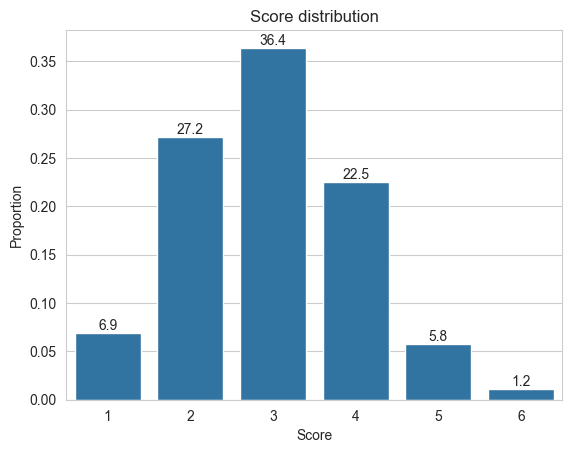

In [26]:
score_count = (
    train_ds["score"]
    .value_counts(normalize=True)
    .rename_axis("score")
    .reset_index(name="proportion")
)
# score_ordered = score_count.score.tolist()
# score_ordered.sort()
ax = sns.barplot(
    x="score",
    y="proportion",
    data=score_count,
    # order=score_ordered
    color=MATPLOTBLUE
)

for p in ax.patches:
    percentage = f"{p.get_height()*100:.1f}" # type: ignore
    x = p.get_x() + p.get_width() / 2 # type: ignore
    y = p.get_height() # type: ignore
    ax.text(x, y, percentage, ha="center", va="bottom")
plt.title("Score distribution")
plt.xlabel("Score")
plt.ylabel("Proportion")
plt.show()
del score_count

The dataset appears to have a distribution that is weighted towards less extreme scores, with a notable decline in the proportion of the highest values. This uneven distribution requires careful consideration during analytical modeling. Special techniques may be necessary to account for the imbalance and to ensure that the analysis is robust, particularly when predicting or interpreting the less represented extreme values.

## What about the text

Addressing the issue of sequence size in the context of natural language processing models, such as [Sentence-BERT](https://arxiv.org/abs/1908.10084), is critical due to the token limit restrictions imposed by these models. Typically, these models cap the number of tokens that can be processed in a single pass, often set at [512 tokens, or sometimes fewer](https://sbert.net/docs/pretrained_models.html). This constraint poses a significant challenge when attempting to encode longer texts, as it necessitates either the omission of content or the application of sophisticated strategies to manage longer sequences effectively. In scholarly discourse, this topic is particularly relevant as it underscores a limitation within state-of-the-art language models when confronted with lengthy documents. It opens up an area for methodological advancements and innovative techniques aimed at preserving the semantic richness of extensive texts without compromising the quality of the generated embeddings. Focusing on the sequence size involves exploring and refining these techniques, which may include partitioning the text into smaller, manageable units while ensuring minimal loss of contextual information. The implications of such methods are profound, impacting both the efficiency of computational processes and the fidelity of text interpretation, especially in domains where the precision of language is paramount. Let's observe the distribution of the text size.

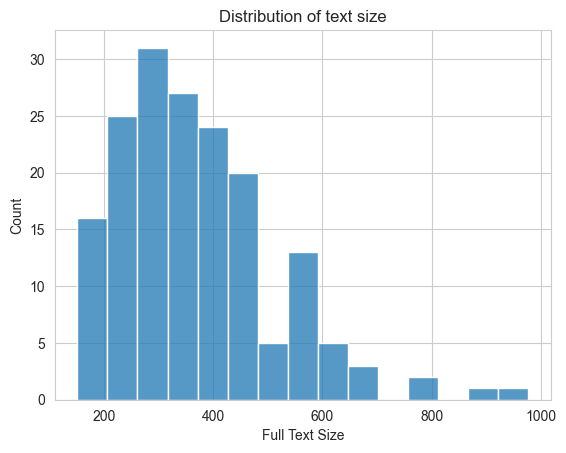

In [27]:
full_text_size = train_ds.full_text.map(lambda x: len(x.split()))
sns.histplot(full_text_size) # type: ignore
plt.xlabel("Full Text Size")
plt.ylabel("Count")
plt.title("Distribution of text size")
plt.show()

The graph highlights a right-skewed distribution of text lengths in a dataset, with most texts falling between 200 to 400 units and a few significantly longer outliers. Multiple peaks suggest the presence of several preferred text lengths. Regarding a potential use of Sentence-BERT for modeling, while adept at producing semantically meaningful sentence embeddings, it may face challenges with these longer texts due to token limits causing memory and computational burdens, potential loss of context when texts are truncated, and inefficiencies in encoding lengthy sequences. This underscores the need for strategic text handling to ensure meaningful semantic encoding by Sentence-BERT, particularly for outlier texts that exceed typical length constraints. To circumvent these limitations, a methodology involving the segmentation of longer texts into individual sentences is proposed, thereby allowing Sentence-BERT to operate within its tokenization parameters while preserving the textual integrity. Such segmentation facilitates detailed semantic analysis of each sentence independently, with the subsequent synthesis of these analyses yielding a comprehensive understanding of the text's overarching semantic structure. Enhancing this segmentation approach, the introduction of overlap between consecutive text chunks is advocated. By ensuring that adjacent segments share a subset of sentences, this strategy aims to safeguard the continuity of information, particularly across segment boundaries. This overlapping ensures the retention of crucial context, which is paramount in the construction of a coherent narrative, particularly for extensive documents where interpretative nuances are intrinsically linked to the broader context.

# Data wrangling

## Turn the score label into ordinal

Ordinal regression is used when the dependent variable (the outcome you're trying to predict) holds an intrinsic order, but the distances between the levels are not known. The classic examples include a Likert scale for surveys (e.g., "strongly disagree," "disagree," "neutral," "agree," "strongly agree"), grades (A, B, C, D, F), or in the case at hand, essay scores. The key advantage of ordinal regression is its ability to handle dependent variables that are more nuanced than simple binary outcomes but don’t have the numeric spacing needed for linear regression. For instance, while we know that grade A is higher than grade B, we cannot say that it is exactly two points higher as we might with numerical scores. This is where ordinal regression comes in—it allows the modeling of the rank order of the dependent variable without making assumptions about the value of the intervals between levels. In the context of modeling essay scores, ordinal regression can predict the rank order of the essays' quality. It is particularly apt for this kind of task because it can learn from the order inherent in the scores without assuming equal spacing between score levels. This can result in more accurate models for ordered categorical data, as it respects the nature of the ranking involved. When using ordinal regression, we need to transform the target variable to reflect the ordinal nature. In a standard regression problem, the target is typically a single column of values. In ordinal regression, however, the target is often expanded into a matrix that represents the ranking order. This matrix enables the model to understand and predict not just whether one essay is better than another but the relative ranking across the spectrum of scores. To prepare for ordinal regression, the scores was transformed into an ordinal matrix with a process known as “one-hot encoding” of the ranks. 

In [28]:
def category_to_ordinal(category):
    y = np.array(category, dtype="int") 
    n = y.shape[0]
    num_class = np.max(y) 
    range_values = np.tile(
        np.expand_dims(np.arange(num_class), 0), 
        [n, 1]
    ) 
    ordinal = np.zeros((n, num_class), dtype="int") 
    ordinal[range_values < np.expand_dims(y, -1)] = 1 
    return ordinal

In [29]:
train_ds["labels"] = category_to_ordinal(train_ds.score.values).tolist()

In [30]:
display(train_ds.head())

,essay_id,full_text,score,labels
12859,bd3ec7d,While there have been presidents that have run...,6,"[1, 1, 1, 1, 1, 1]"
1744,1b0037e,Is studying Venus a worthy pursuit despite the...,2,"[1, 1, 0, 0, 0, 0]"
5646,545a0f3,Luke Bomberger had a friend who asked him to t...,1,"[1, 0, 0, 0, 0, 0]"
6041,5a7d2db,"In the article ""The Challenge of Exploring Ven...",2,"[1, 1, 0, 0, 0, 0]"
7336,6e0d125,The Face\n\nSome people don't believe the Face...,3,"[1, 1, 1, 0, 0, 0]"


## Create training / validation set

In [31]:
train_set, validation_set = train_test_split(
    train_ds, 
    train_size=.7, 
    random_state=SEED, 
    stratify=train_ds.score
)

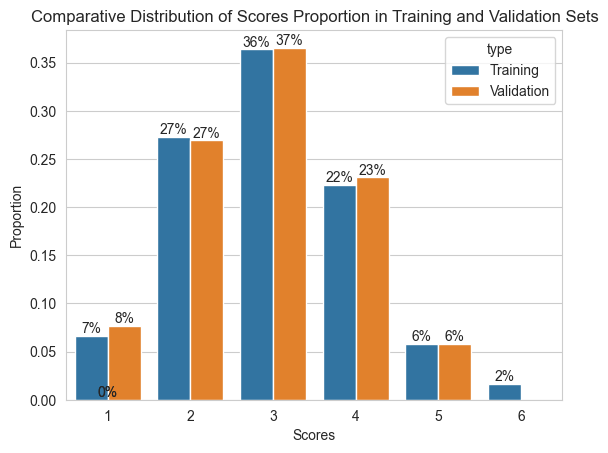

In [32]:
train_set_tmp = train_set.copy()
validation_set_tmp = validation_set.copy()

train_set_tmp["type"] = "Training"
validation_set_tmp["type"] = "Validation"
# ingnore_index force the creation of a new index.
combined_set = pd.concat(
    [train_set_tmp, validation_set_tmp], 
    ignore_index=True
)

proportion = (
    combined_set.groupby("type")["score"]
    .value_counts(normalize=True)
    .reset_index()
)

ax = sns.barplot(proportion, x="score", y="proportion", hue="type")

for p in ax.patches:
    percentage = f"{p.get_height()*100:.0f}%" # type: ignore
    x = p.get_x() + p.get_width() / 2 # type: ignore
    y = p.get_height() # type: ignore
    ax.text(x, y, percentage, ha="center", va="bottom")

plt.title("Comparative Distribution of Scores Proportion in Training and Validation Sets")
plt.xlabel("Scores")
plt.ylabel("Proportion")
plt.show()

del(train_set_tmp)
del(validation_set_tmp)

The provided plot presents a grouped bar chart depicting the distribution of scores within two distinct datasets: Training and Validation. Each score category from 1 to 6 is represented by a pair of bars—one for the Training set (in blue) and one for the Validation set (in orange). The stratification ensures that the proportion of scores in each score category is consistent across both training and validation sets. This consistency is critical when developing a model for ordinal regression, as it allows the model to learn from a training set that mirrors the real-world or expected distribution of scores. Consequently, when the model is validated, the validation set similarly reflects this distribution, allowing for an accurate assessment of the model's performance. From the visual comparison of the bar heights, it is evident that each score's representation in the training set closely matches its representation in the validation set.

In [33]:
type(validation_set)
data_dict = datasets.DatasetDict({
    "training": datasets.Dataset.from_pandas(df=train_set),
    "validation": datasets.Dataset.from_pandas(df=validation_set)
})

# Modeling usin DeBERTa

The development of Bidirectional Encoder Representations from Transformers (BERT, [Delvin et al., 2018](https://arxiv.org/abs/1810.04805)) marked a significant advancement in natural language processing by introducing bidirectional training of Transformer models. This was a departure from previous unidirectional models and utilized strategies such as masked language modeling and next sentence prediction. Subsequent derivatives include Robustly Optimized BERT Pretraining Approach (RoBERTa, [Liu et al., 2019](https://arxiv.org/abs/1907.11692)), which optimized BERT by eliminating the next sentence prediction requirement and adjusting training conditions. DistilBERT ([Sanh et al., 2019](https://arxiv.org/abs/1910.01108)) offered a streamlined version retaining 95% of BERT's performance but with reduced size and enhanced speed through knowledge distillation ([Hinton, Vinyals and Dean, 2015](https://arxiv.org/abs/1503.02531)). Google Research introduced A Lite BERT (ALBERT, [Lan et al., 2019](https://arxiv.org/abs/1909.11942)), which minimized memory usage and complexity, improve parameter efficiency and accelerated training by implementing techniques like factorized embedding parameterization and cross-layer parameter sharing. Lastly, Decoding-enhanced BERT with Disentangled Attention (DeBERTa), developed by Microsoft Research and detailed by He et al. in 2020, enhanced the understanding of context and position in language models. ([He et al., 2020](https://arxiv.org/abs/2006.03654))

Indeed, DeBERTa has evolved through several versions, each introducing significant advancements over its predecessors in the realm of natural language processing. The original version, DeBERTa V1 ([He et al., 2020](https://arxiv.org/abs/2006.03654)), introduced a disentangled attention mechanism that separately processes content and positional information, enabling a more nuanced understanding of word contexts. It also featured an enhanced mask decoder that improved syntax and semantic analysis by predicting both masked tokens and their relative positions. Building on V1, [DeBERTa V2](https://huggingface.co/docs/transformers/v4.40.0/model_doc/deberta-v2) incorporated more advanced training techniques and introduced an XXL model size, which substantially boosted performance across various NLP benchmarks. The latest iteration, DeBERTa V3 ([He et al., 2021](https://arxiv.org/abs/2111.09543)), further refined these capabilities by adopting ELECTRA-style pre-training, which enhances efficiency by training the model to differentiate between correct and incorrect token replacements.

**One way forward**: [BitFit: Simple Parameter-efficient Fine-tuning for Transformer-based Masked Language-models](https://arxiv.org/abs/2106.10199)

The paper "BitFit: Simple Parameter-efficient Fine-tuning for Transformer-based Masked Language-models" presents a novel fine-tuning method for large transformer models, such as BERT and its variants, which optimizes a minimal subset of parameters—specifically the bias terms—while keeping the rest unchanged. This method leverages the finding that updating just the bias parameters can achieve performance comparable to, or sometimes surpassing, that of full model fine-tuning, particularly in situations with limited computational resources or sparse training data. BitFit's approach is highly efficient as it targets only a small fraction of the total model parameters, enhancing its utility in resource-constrained settings. Additionally, its simplicity accelerates training and adaptation, making it ideal for rapid deployment and frequent updates. Importantly, by freezing most of the parameters, BitFit preserves the general knowledge acquired during pre-training, thereby avoiding overfitting on specific fine-tuning datasets and allowing for effective adaptation to new tasks or minor domain shifts without extensive retraining.

In this section, we modelize using DeBERTa as checkpoint. (+ context M&M)

## Tokenize the text

Tokenization is a fundamental process in natural language processing (NLP) where text is segmented into smaller units known as tokens. These tokens may be individual words, characters, or subwords. This segmentation is akin to parsing a sentence into its constituent words or decomposing a word into syllables. 

In [34]:
deberta_v3_tokenizer = AutoTokenizer.from_pretrained(
    configuration_item.model_ckpt
)
deberta_v3_mdl = AutoModelForSequenceClassification.from_pretrained(
    configuration_item.model_ckpt
 )

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
from datasets.arrow_dataset import Dataset


def encode(batch, tokenizer):
    return tokenizer(
        batch["full_text"], 
        padding=True,
        return_tensors="pt"
    )
data_dict: DatasetDict = data_dict.map(
    encode,
    batched=True,
    batch_size=1000,
    fn_kwargs={"tokenizer": deberta_v3_tokenizer}
)
data_collator = DataCollatorWithPadding(
    tokenizer=deberta_v3_tokenizer,
    return_tensors="pt"
)

training_torch: Dataset = (
    data_dict["training"]
    .select_columns(["input_ids", "labels", "attention_mask"])
    .with_format("torch", device=configuration_item.torch_device) 
)
validation_torch: Dataset = (
    data_dict["validation"]
    .select_columns(["input_ids", "labels", "attention_mask"])
    .with_format("torch", device=configuration_item.torch_device)
)
DataLoader(training_torch, batch_size=64, shuffle=True, collate_fn=data_collator) # type: ignore
training_dataloader = DataLoader(training_torch, batch_size=64, shuffle=True, collate_fn=data_collator) # type: ignore
validation_dataloader = DataLoader(validation_torch, batch_size=64, shuffle=True, collate_fn=data_collator) # type: ignore
del training_torch
del validation_torch


Map:   0%|          | 0/121 [00:00<?, ? examples/s]

Map:   0%|          | 0/52 [00:00<?, ? examples/s]

**Important Note**: The `DataCollatorWithPadding` modifies column names by changing `label` to `labels` (if the column exists). For the sake of conciseness and readability, I have updated all occurrences of `label` to `labels` throughout the code. This specific transformation is detailed in the `__call__` function of the [`DataCollatorWithPadding`](https://github.com/huggingface/transformers/blob/v4.40.2/src/transformers/data/data_collator.py#L236).

## Set the classifier

In this section, I outline the structural framework for our model, incorporating an innovative technique known as Low-Rank Adaptation (LoRA) as proposed by [Yu et al., 2023](https://arxiv.org/abs/2309.15223) **TODO: quantization**. LoRA is a method specifically designed to enhance the efficiency of fine-tuning large pre-trained models. This is achieved by reducing the number of trainable parameters, thereby simplifying the model adaptation process and decreasing the computational overhead. The key advantage of using LoRA lies in its ability to retain the performance of the original model while significantly cutting down on the resources required for fine-tuning. This is accomplished by introducing low-rank matrices that modify the existing weights of a pre-trained model rather than retraining all parameters. This selective updating allows us to maintain a balance between computational efficiency and model effectiveness. Implementing LoRA involves decomposing the parameter matrices into smaller, more manageable components, which are easier to optimize. This method not only speeds up the adaptation process but also reduces the memory footprint, making it feasible to fine-tune large models on more modest hardware setups.

In the `EncoderForOrdinalRegression` class designed for ordinal regression, a linear function is trained from a sigmoid activation to be consistent with the ordinal labels. Specifically, the linear layer is configured with five output nodes corresponding to the five ordinal values of the label. During the forward pass, this layer processes the extracted features and returns the sigmoid of the logits, effectively translating the raw logits into probabilities that are suitable for ordinal classification. This architecture allows for a nuanced interpretation of output probabilities directly aligned with the ordered categories inherent to the task.

In [36]:
class EncoderForOrdinalRegression(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.pretrained = AutoModel.from_pretrained(config.model_ckpt)
        self.pretrained.to(config.torch_device)
        self.output_layer = nn.Linear(
            self.pretrained.config.hidden_size,
            config.num_labels
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.pretrained(
            ## deberta forward method that overrides the __call__
            ## https://huggingface.co/docs/transformers/v4.40.2/en/model_doc/deberta-v2#transformers.DebertaV2Model.forward
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = self.output_layer(
            # Only keeping the [CLS] token
            outputs.last_hidden_state[:, 0, :]
        )
        probs = torch.sigmoid(logits)
        return probs


## Build the training loop 

The `train_model` function is designed to train and evaluate a PyTorch model across a specified number of epochs using both training and evaluation datasets. This function initializes a binary cross-entropy loss criterion and orchestrates the training loop, ensuring each epoch runs through both the training data and evaluation data to compute and display losses. It leverages helper functions `run_epoch` to process each epoch and `validate_dataset_columns` to check that the necessary data columns are present in the dataset.

In [45]:
from typing import Any, List

def train_model(
    model: nn.Module, 
    train_loader: torch.utils.data.DataLoader, 
    eval_loader: torch.utils.data.DataLoader, 
    optimizer: torch.optim.Optimizer, 
    config,
    epochs: int = 3
):
    """
    Train a PyTorch model and evaluate it.

    Parameters:
        model (nn.Module): The model to train and evaluate.
        train_loader (DataLoader): DataLoader for training data.
        eval_loader (DataLoader): DataLoader for evaluation data.
        optimizer (Optimizer): The optimizer for training.
        config: Configuration object with attributes like device.
        epochs (int): Number of training epochs.
    """
    required_columns: List[str] = ["input_ids", "attention_mask", "labels"]
    validate_dataset_columns(train_loader, required_columns)
    validate_dataset_columns(eval_loader, required_columns)

    criterion = nn.BCELoss()

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        train_loss: float = run_epoch(
            model, 
            train_loader, 
            optimizer, 
            criterion, 
            config.torch_device, 
        )
        eval_loss: float = run_epoch(
            model, 
            eval_loader, 
            optimizer, 
            criterion, 
            config.torch_device, 
            training=False
        )

        print(f"Mean Training Loss: {train_loss}")
        print(f"Mean Evaluation Loss: {eval_loss}")

def run_epoch(model, loader, optimizer, criterion, device, training=True) -> float:
    """ Run a training or evaluation epoch """
    if training:
        model.train()
    else:
        model.eval()

    total_loss = 0
    with torch.set_grad_enabled(training):
        for batch in loader:
            batch = {
                k: v.to(device) 
                for k, v in batch.items() 
                if k in ["input_ids", "attention_mask", "labels"]
            }
            input_ids, mask, labels = tuple([
                batch["input_ids"],
                batch["attention_mask"], 
                batch["labels"]
            ])
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=mask)
            loss = criterion(outputs, labels.float())
            if training:
                loss.backward()
                optimizer.step()
            total_loss += loss.item()
    return total_loss / len(loader)

def validate_dataset_columns(loader, columns):
    """ Ensure loader contains all necessary columns """
    sample_batch = next(iter(loader))
    for column in columns:
        if column not in sample_batch:
            raise ValueError(f"Column {column} missing from DataLoader")

## Train !

Let's train ...

In [46]:
model = EncoderForOrdinalRegression(configuration_item)
optimizer = AdamW(model.parameters(), lr=2e-5)
train_model(
    model=model,
    train_loader=training_dataloader,
    eval_loader=validation_dataloader,
    optimizer=optimizer,
    config=configuration_item
)

Epoch 1/3


KeyboardInterrupt: 

# TODO stuff

In [ ]:

# TODO: 


class EncoderClassifier(BaseEstimator, ClassifierMixin):
    """
    A classifier that encapsulates an encoder network for 
    feature extraction followed by classification.

    Attributes:
        encoder_network (EncoderNetwork): An instance of EncoderNetwork 
            used for encoding input data.
        conf (dict, optional): Configuration dictionary for 
            classifier specific settings.
    """
    def __init__(self, encoder_network, config=None):
        """
        Initialize the EncoderClassifier with an encoder network 
        and an optional configuration.

        Parameters:
            encoder_network (EncoderNetwork): The encoder network 
                to use for data encoding.
            conf (dict, optional): Additional configuration for 
                the classifier. Defaults to None.
        """
        self.encoder_network = encoder_network
        self.config = config if config is not None else {}

    def fit(self, X, y):
        """
        Fit the classifier to the training data. 
        This method should implement learning from the data.

        Parameters:
            X (array-like): Training data features.
            y (array-like): Training data labels or target values.
        """
        pass

    def predict(self, X):
        """
        Predict the labels of the input data using the trained classifier.

        Parameters:
            X (array-like): Data features for which 
                predictions are to be made.

        Returns:
            array: Predicted labels for the input data.
        """
        pass

# Modeling using ALBERT